In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Cargar el archivo CSV
df = pd.read_csv('Integracion_con_patógenos_y_enfermedades_Propionibacterium_F_Padj_menor_0.05.csv')
# Mostrar las primeras filas y la informaci\u00f3n del DataFrame
df.head()


,Genes,DisGeNET_Term,DisGeNET_Pvalue_Adjusted,GeDiPNet_Term,GeDiPNet_Pvalue_Adjusted,Orphanet_Term,Orphanet_Pvalue_Adjusted,Virus_Host_Term,Virus_Host_Pvalue_Adjusted,Host organism(s)_Intact,Confidence value(s)_Intact,Taxid interactor A_Intact,Taxid interactor B_Intact
0,AATK,NaN,NaN,NaN,NaN,Hereditary sensory and autonomic neuropathy du...,0.0155394890951578; 0.0184072076199886,NaN,NaN,NaN,NaN,NaN,NaN
1,ABCA7,NaN,NaN,NaN,NaN,Autosomal dominant centronuclear myopathy ORPH...,0.0036432528126817; 0.0081550609410495; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN
2,ACAP3,NaN,NaN,NaN,NaN,Otospondylomegaepiphyseal dysplasia ORPHA:1427...,0.0144185025972157; 0.0155394890951578; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN
3,ACOT7,NaN,NaN,NaN,NaN,PRKAR1B-related neurodegenerative dementia wit...,0.0155394890951578,NaN,NaN,NaN,NaN,NaN,NaN
4,ADAM8,NaN,NaN,NaN,NaN,Idiopathic CD4 lymphocytopenia ORPHA:228000; P...,0.0155394890951578; 0.0155394890951578; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN


    Gene DisGeNET_Term_categories GeDiPNet_Term_categories  \
0   AATK           No information           No information   
1  ABCA7           No information           No information   
2  ACAP3           No information           No information   
3  ACOT7           No information           No information   
4  ADAM8           No information           No information   

                            Orphanet_Term_categories  
0                                     Other Diseases  
1  Neurological Diseases, Associated with Dysbios...  
2              Neurological Diseases, Other Diseases  
3                                     Other Diseases  
4                     Viral Diseases, Other Diseases  
Graph saved as 'disease_categories_barplot.png'


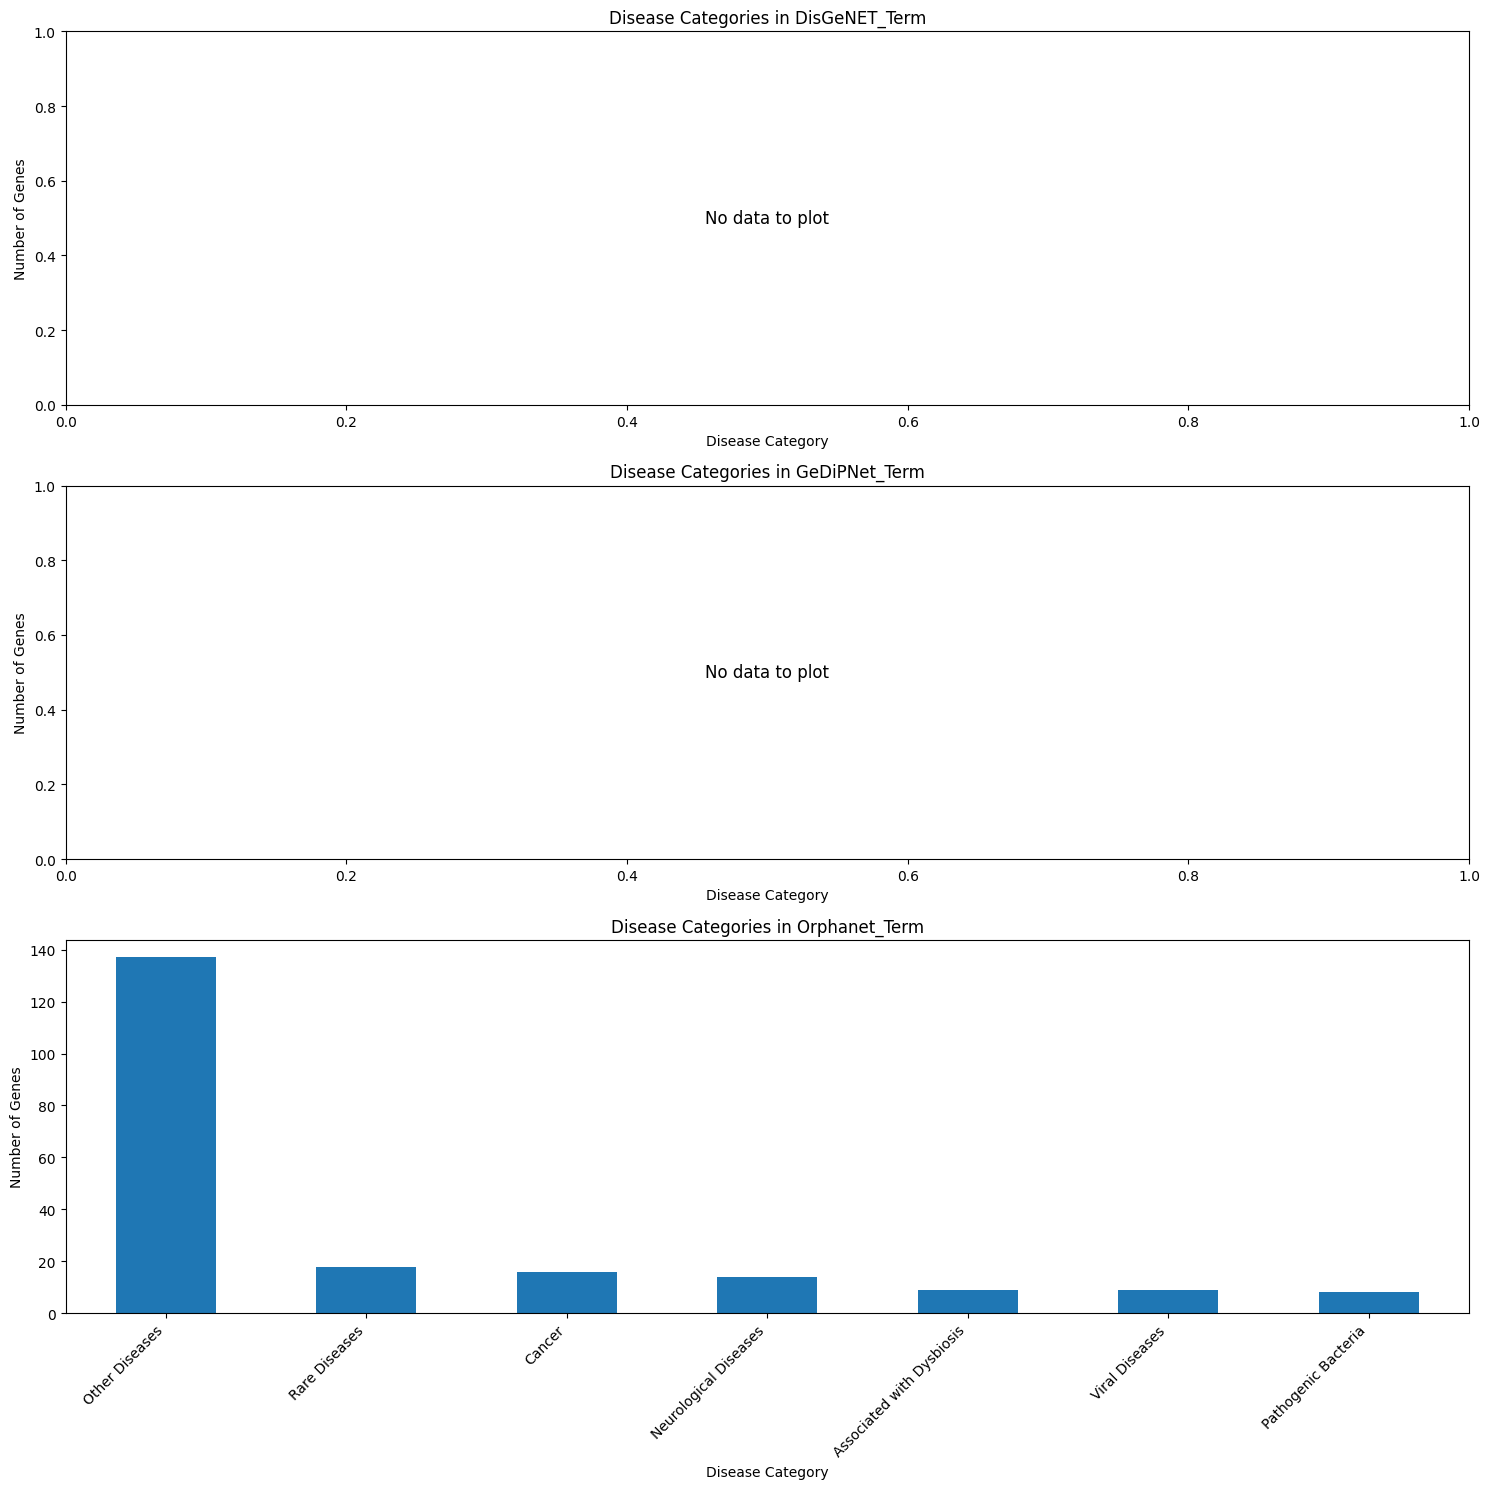

In [3]:


# Define disease categories
categories = {
    "Cancer": ["carcinoma", "cancer", "tumor", "neoplasm", "leukemia", "lymphoma", "sarcoma", "melanoma"],
    "Neurological Diseases": ["neurological", "amyotrophic", "parkinson", "alzheimer", "epilepsy", "schizophrenia", "bipolar disorder", "autism"],
    "Viral Diseases": ["viral", "HIV", "hepatitis", "influenza", "covid", "ebola", "dengue", "zika", "chikungunya"],
    "Pathogenic Bacteria": ["bacterial", "bacteria", "tuberculosis", "streptococcus", "staphylococcus", "pneumonia", "salmonella", "e. coli", "bacterial infection"],
    "Associated with Dysbiosis": ["dysbiosis", "gut microbiota", "intestinal microbiota", "inflammatory bowel disease", "irritable bowel syndrome", "non-alcoholic fatty liver disease", 
                                  "celiac disease", "necrotizing enterocolitis", "helicobacter pylori", "obesity", "diabetes", "anxiety", "stress", "digestive system"],
    "Rare Diseases": ["Ehlers-Danlos syndrome", "Charcot-Marie-Tooth disease", "epidermolysis bullosa", "citrullinemia", "amyloidosis", "glycogen storage disease", 
                       "rare disease", "orphan disease", "nephrotic syndrome", "glomerulonephritis", "autoimmune", "immunodeficiency"],
    "Other Diseases": []  # Unclassified diseases
}

def classify_disease(disease):
    # Check if the disease is NaN or "No information"
    if pd.isna(disease) or disease.lower() == "no information":
        return "No information"
    
    # Convert to lowercase for case-insensitive comparison
    disease = disease.lower()
    
    # Search for matches in the defined categories
    for category, keywords in categories.items():
        if any(keyword in disease for keyword in keywords):
            return category
            
    # If no match found, return "Other Diseases"
    return "Other Diseases"

def process_disease_column(column):
    if pd.isna(column):
        return ["No information"]
    diseases = column.split(';')
    return [disease.strip() for disease in diseases]

# Process disease columns
disease_columns = ['DisGeNET_Term', 'GeDiPNet_Term', 'Orphanet_Term']

for col in disease_columns:
    df[f'{col}_processed'] = df[col].apply(process_disease_column)
    df[f'{col}_categories'] = df[f'{col}_processed'].apply(lambda x: [classify_disease(disease) for disease in x])

# Create a new DataFrame with the mapping
gene_disease_mapping = pd.DataFrame()
gene_disease_mapping['Gene'] = df['Genes']

for col in disease_columns:
    gene_disease_mapping[f'{col}_categories'] = df[f'{col}_categories'].apply(lambda x: ', '.join(set(x)))

# Show the first rows of the new DataFrame
print(gene_disease_mapping.head())

# Count the disease categories for each source, excluding "No information"
category_counts = {}
for col in disease_columns:
    # Exclude "No information"
    filtered_categories = gene_disease_mapping[f'{col}_categories'].apply(
        lambda x: ', '.join([cat for cat in x.split(', ') if cat != 'No information'])
    )
    # Count the categories
    category_counts[col] = filtered_categories.str.get_dummies(sep=', ').sum().sort_values(ascending=False)

# Create a bar plot for each disease source
fig, axes = plt.subplots(len(disease_columns), 1, figsize=(15, 5 * len(disease_columns)))

for i, (source, counts) in enumerate(category_counts.items()):
    ax = axes[i]
    if counts.empty:
        ax.text(0.5, 0.5, 'No data to plot', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(f'Disease Categories in {source}')
        ax.set_xlabel('Disease Category')
        ax.set_ylabel('Number of Genes')
    else:
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Disease Categories in {source}')
        ax.set_xlabel('Disease Category')
        ax.set_ylabel('Number of Genes')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('disease_categories_barplot.png')
print("Graph saved as 'disease_categories_barplot.png'")


In [4]:
gene_disease_mapping

,Gene,DisGeNET_Term_categories,GeDiPNet_Term_categories,Orphanet_Term_categories
0,AATK,No information,No information,Other Diseases
1,ABCA7,No information,No information,"Neurological Diseases, Associated with Dysbios..."
2,ACAP3,No information,No information,"Neurological Diseases, Other Diseases"
3,ACOT7,No information,No information,Other Diseases
4,ADAM8,No information,No information,"Viral Diseases, Other Diseases"
...,...,...,...,...
137,ZNF516,No information,No information,Other Diseases
138,ZNF598,No information,No information,Other Diseases
139,ZNF628,No information,No information,Other Diseases
140,ZNF653,No information,No information,Other Diseases


## Tablas resumen por categoría

Dado que ya tenemos las categorías de enfermedades clasificadas para cada gen, podríamos generar tablas de resumen que permitan obtener una visión general de cuántos genes están asociados a cada categoría de enfermedad

In [5]:
# Function to count the number of genes by category
def count_genes_by_category(df, disease_column_categories):
    category_counts = {}
    for categories in df[disease_column_categories]:
        for category in categories.split(', '):  # Split to handle multiple categories per gene
            category_counts[category] = category_counts.get(category, 0) + 1
    return category_counts

# Create a DataFrame with gene counts by category for each disease column
summary_tables = {}

for col in disease_columns:
    category_counts = count_genes_by_category(gene_disease_mapping, f'{col}_categories')
    summary_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Number of Genes'])
    summary_tables[col] = summary_df

# Display summary tables for each column
for col, summary_df in summary_tables.items():
    print(f"Summary for {col}:")
    print(summary_df)
    print("\n")


Summary for DisGeNET_Term:
         Category  Number of Genes
0  No information              142


Summary for GeDiPNet_Term:
         Category  Number of Genes
0  No information              142


Summary for Orphanet_Term:
                    Category  Number of Genes
0             Other Diseases              137
1      Neurological Diseases               14
2  Associated with Dysbiosis                9
3             Viral Diseases                9
4                     Cancer               16
5              Rare Diseases               18
6        Pathogenic Bacteria                8




## Explorar genes asociados a múltiples categorías
Podríamos analizar qué genes están asociados a múltiples categorías de enfermedades, lo que podría indicar un rol relevante en diferentes contextos biológicos o patológicos.

In [6]:
# Function to find genes associated with multiple categories
def genes_in_multiple_categories(df, disease_column_categories):
    multiple_categories_genes = df[df[disease_column_categories].apply(lambda x: len(set(x.split(', '))) > 1)]
    return multiple_categories_genes

# Apply the function to each disease column
for col in disease_columns:
    multi_category_genes = genes_in_multiple_categories(gene_disease_mapping, f'{col}_categories')
    print(f"Genes associated with multiple categories in {col}:")
    print(multi_category_genes[['Gene', f'{col}_categories']])
    print("\n")


Genes associated with multiple categories in DisGeNET_Term:
Empty DataFrame
Columns: [Gene, DisGeNET_Term_categories]
Index: []


Genes associated with multiple categories in GeDiPNet_Term:
Empty DataFrame
Columns: [Gene, GeDiPNet_Term_categories]
Index: []


Genes associated with multiple categories in Orphanet_Term:
         Gene                           Orphanet_Term_categories
1       ABCA7  Neurological Diseases, Associated with Dysbios...
2       ACAP3              Neurological Diseases, Other Diseases
4       ADAM8                     Viral Diseases, Other Diseases
5      AGPAT2                             Cancer, Other Diseases
7      ARID5A                     Viral Diseases, Other Diseases
8     ATG16L2              Neurological Diseases, Other Diseases
10    B3GALT4                     Viral Diseases, Other Diseases
16      CCNA2              Cancer, Rare Diseases, Other Diseases
17      CCNB1              Cancer, Rare Diseases, Other Diseases
18      CCNB2              Can

In [7]:
# Exportar el mapeo completo de genes a CSV
gene_disease_mapping.to_csv('gene_disease_mapping.csv', index=False)

# Exportar las tablas resumen a archivos CSV
for col, summary_df in summary_tables.items():
    summary_df.to_csv(f'summary_{col}.csv', index=False)

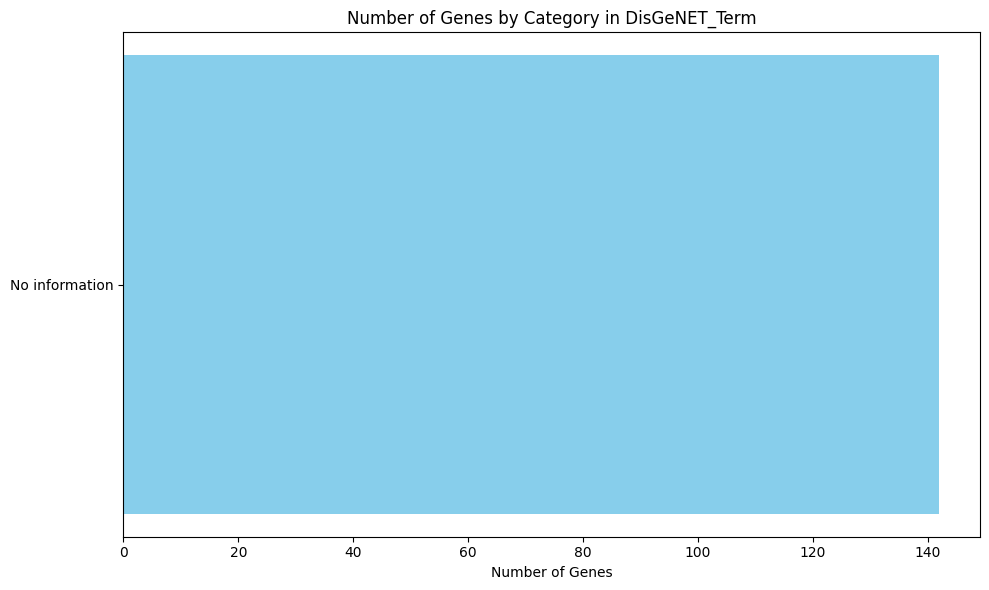

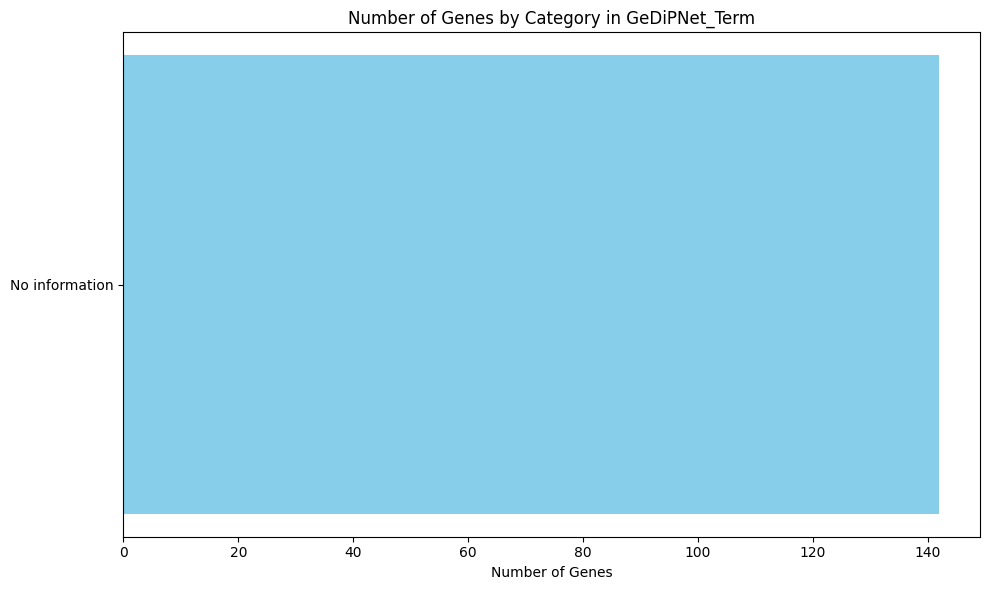

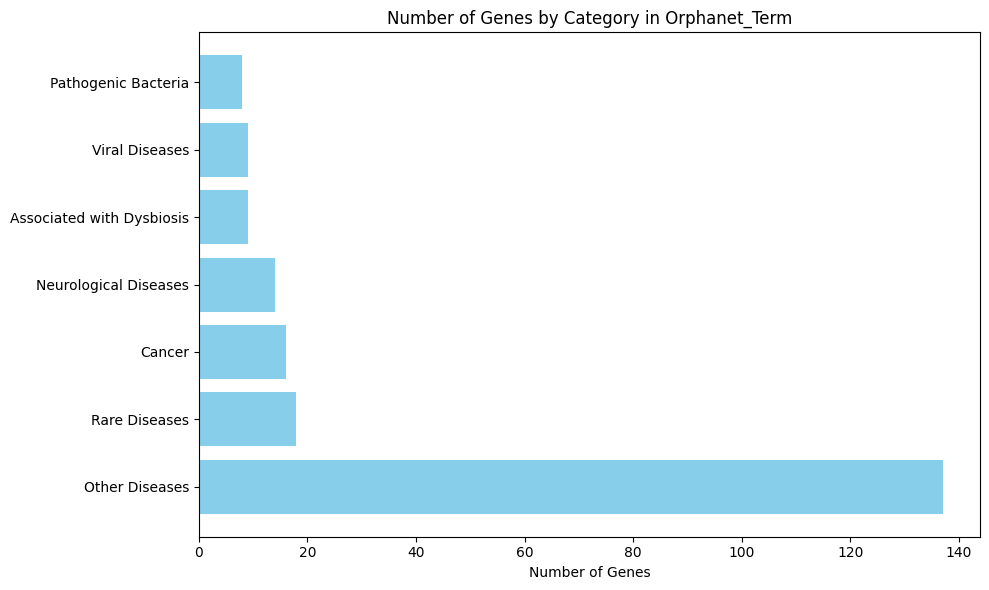

In [8]:

# Function to generate a bar chart by category
def plot_category_distribution(summary_df, title):
    summary_df.sort_values(by='Number of Genes', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    plt.barh(summary_df['Category'], summary_df['Number of Genes'], color='skyblue')
    plt.xlabel('Number of Genes')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generate bar charts for each disease column
for col, summary_df in summary_tables.items():
    plot_category_distribution(summary_df, f'Number of Genes by Category in {col}')


## Procedimiento para obtener tablas de genes por categoría:
A continuación podemos organizar los genes asociados a cada una de las categorías de enfermedades:

Agrupar los genes por cada categoría: De acuerdo a las categorías que ya definidas en categories, puedemos filtrar los genes que están asociados con las enfermedades correspondientes.

Crear tablas para cada categoría: Para cada categoría de enfermedad, crear un subconjunto del DataFrame que contenga solo los genes relacionados con dicha categoría.

In [9]:
# Inicializar un diccionario para almacenar genes por categoría
genes_by_category = {category: [] for category in categories.keys()}

# Función para agregar genes a las categorías correspondientes
def classify_genes_by_category(row):
    for col in disease_columns:
        for category in row[f'{col}_categories'].split(', '):
            if category in genes_by_category:
                genes_by_category[category].append(row['Gene'])

# Aplicar la función a cada fila del DataFrame
gene_disease_mapping.apply(classify_genes_by_category, axis=1)

# Eliminar duplicados de cada lista de genes por categoría
genes_by_category = {category: list(set(genes)) for category, genes in genes_by_category.items()}

# Mostrar genes agrupados por categoría
for category, genes in genes_by_category.items():
    print(f"Categoría: {category}")
    print(f"Genes: {', '.join(genes)}\n")


Categoría: Cancer
Genes: KLF4, SLC16A3, CDA, CEBPB, CDC25C, PLIN3, KIF20A, CENPA, AGPAT2, CCNB2, CCNA2, CCNB1, PLK4, TCIRG1, ZWINT, ITPRIP

Categoría: Neurological Diseases
Genes: ACAP3, PGS1, ATG16L2, SGSM2, CORO1A, REC8, SH2D3C, PAN2, NXF1, USP20, OSBPL7, KIFC2, ABCA7, TUBGCP6

Categoría: Viral Diseases
Genes: B3GALT4, CORO1A, ADAM8, ISG15, OASL, SPSB3, TCIRG1, ARID5A, TREX1

Categoría: Pathogenic Bacteria
Genes: CCND3, RPUSD1, YIF1B, STARD3, SPSB3, EHD1, TCIRG1, LMF2

Categoría: Associated with Dysbiosis
Genes: HERC1, SEC16A, DYRK1B, IQSEC1, USP20, SNX29, KIAA0513, ABCA7, PLEKHM1

Categoría: Rare Diseases
Genes: EHD1, CDC25C, KIF20A, SLC19A2, RPUSD1, LMF2, TLCD1, CENPA, STARD3, CCNB2, CCNA2, CCNB1, PLK4, SPSB3, YIF1B, ZWINT, TCIRG1, CCND3

Categoría: Other Diseases
Genes: IGSF8, BAIAP2, USP20, AGPAT2, TCIRG1, TRIP10, SLC16A3, CEBPB, SYNPO, NUAK1, TNKS1BP1, ZNF516, PGS1, ADAM8, SH2D3C, VASN, EHD1, CDH1, MAPKAPK2, RPUSD1, ZNF628, SYNGR3, SNPH, CORO1A, CTIF, EVI5L, CDKN2B, TCAP, CCNA2,

In [10]:
# Crear un DataFrame para cada categoría
tables_by_category = {}

for category, genes in genes_by_category.items():
    tables_by_category[category] = pd.DataFrame(genes, columns=['Gene'])

# Mostrar la tabla para una categoría específica (ejemplo: "Cáncer")
print(tables_by_category['Cancer'])


       Gene
0      KLF4
1   SLC16A3
2       CDA
3     CEBPB
4    CDC25C
5     PLIN3
6    KIF20A
7     CENPA
8    AGPAT2
9     CCNB2
10    CCNA2
11    CCNB1
12     PLK4
13   TCIRG1
14    ZWINT
15   ITPRIP


In [11]:
# Exportar tablas a CSV
for category, table in tables_by_category.items():
    table.to_csv(f'genes_{category}.csv', index=False)


DataFrame que contenga todas las categorías de enfermedades, agrupando los genes en una sola estructura:

In [12]:
# Create a list to store gene data and their categories
gene_category_data = []

# Function to add each gene and the categories it belongs to
def append_gene_category_data(row):
    for col in disease_columns:
        for category in row[f'{col}_categories'].split(', '):
            gene_category_data.append([row['Gene'], category])

# Apply the function to add data for each row
gene_disease_mapping.apply(append_gene_category_data, axis=1)

# Create the DataFrame with gene and category data
df_genes_categories = pd.DataFrame(gene_category_data, columns=['Gene', 'Category'])

# Display the first rows of the DataFrame
print(df_genes_categories.head())


    Gene        Category
0   AATK  No information
1   AATK  No information
2   AATK  Other Diseases
3  ABCA7  No information
4  ABCA7  No information


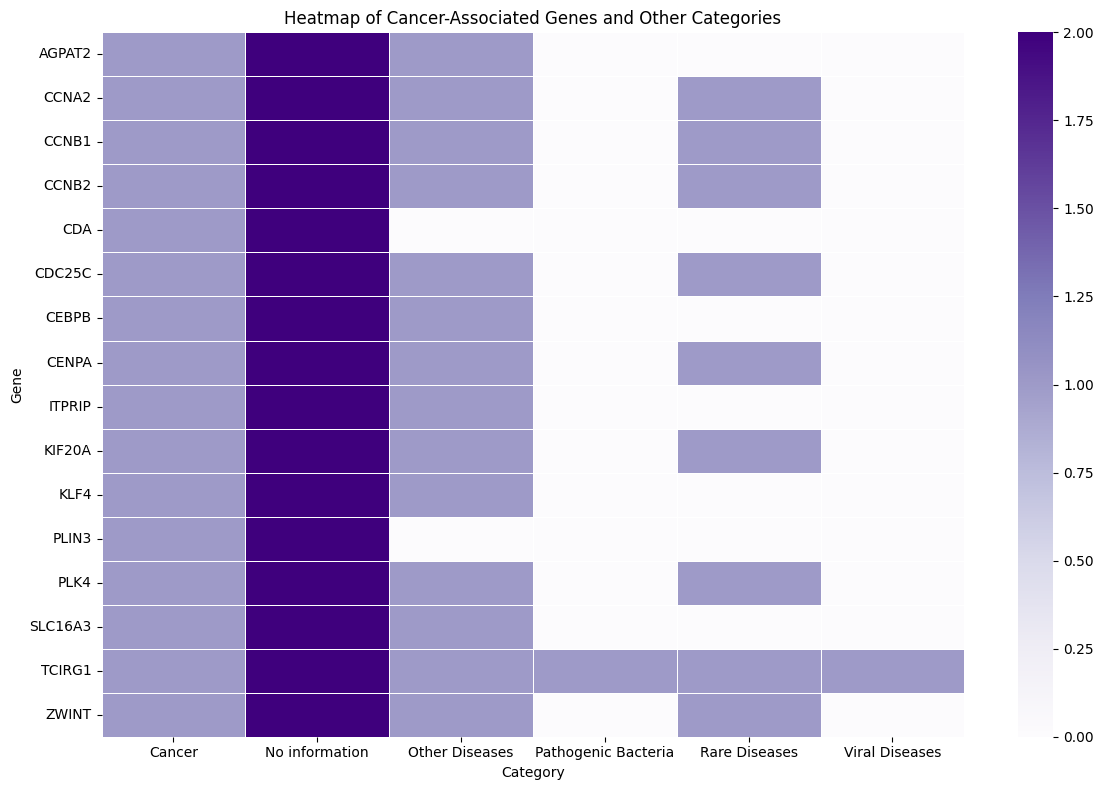

In [18]:


# Paso 1: Filtrar genes asociados a la categoría "Cáncer"
df_cancer_genes = df_genes_categories[df_genes_categories['Category'] == 'Cancer']

# Paso 2: Obtener todos los genes asociados a "Cáncer"
cancer_genes = df_cancer_genes['Gene'].unique()

# Filtrar el DataFrame original para obtener las categorías de estos genes
df_cancer_related_categories = df_genes_categories[df_genes_categories['Gene'].isin(cancer_genes)]

# Paso 3: Crear una tabla pivote (gene-category matrix) donde se muestren las asociaciones
# Esto genera una matriz donde las filas son los genes y las columnas son las categorías
df_pivot = df_cancer_related_categories.pivot_table(index='Gene', columns='Category', aggfunc='size', fill_value=0)

# Paso 4: Generar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap='Purples', linewidths=0.5)
plt.title('Heatmap of Cancer-Associated Genes and Other Categories')
plt.tight_layout()

# Mostrar el heatmap
plt.show()

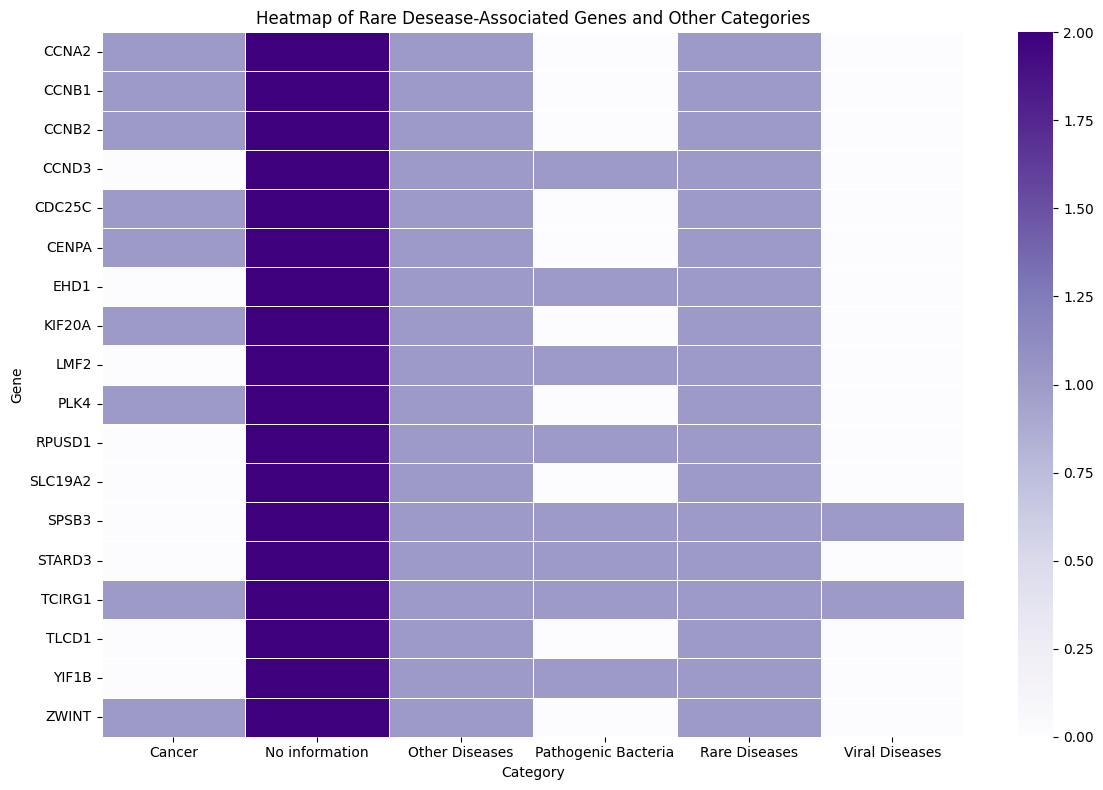

In [19]:
# Paso 1: Filtrar genes asociados a la categoría "Cáncer"
df_cancer_genes = df_genes_categories[df_genes_categories['Category'] == 'Rare Diseases']

# Paso 2: Obtener todos los genes asociados a "Cáncer"
cancer_genes = df_cancer_genes['Gene'].unique()

# Filtrar el DataFrame original para obtener las categorías de estos genes
df_cancer_related_categories = df_genes_categories[df_genes_categories['Gene'].isin(cancer_genes)]

# Paso 3: Crear una tabla pivote (gene-category matrix) donde se muestren las asociaciones
# Esto genera una matriz donde las filas son los genes y las columnas son las categorías
df_pivot = df_cancer_related_categories.pivot_table(index='Gene', columns='Category', aggfunc='size', fill_value=0)

# Paso 4: Generar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap='Purples', linewidths=0.5)
plt.title('Heatmap of Rare Desease-Associated Genes and Other Categories')
plt.tight_layout()

# Mostrar el heatmap
plt.show()

In [20]:
# Group categories by each gene and combine them into a single comma-separated list
df_genes_grouped = df_genes_categories.groupby('Gene')['Category'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()

# Filter the DataFrame to remove rows with categories "No information" or "Other Diseases"
df_filtered = df_genes_categories[~df_genes_categories['Category'].isin(["No information", "Other Diseases"])]

# Group categories by each gene and combine them into a single comma-separated list
df_genes_grouped = df_filtered.groupby('Gene')['Category'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()

# Display the first rows of the grouped DataFrame
print(df_genes_grouped.head())


     Gene                                          Category
0   ABCA7  Associated with Dysbiosis, Neurological Diseases
1   ACAP3                             Neurological Diseases
2   ADAM8                                    Viral Diseases
3  AGPAT2                                            Cancer
4  ARID5A                                    Viral Diseases


In [21]:
# Filter genes associated with multiple categories (more than one category)
df_genes_multiple_categories = df_genes_grouped[df_genes_grouped['Category'].apply(lambda x: len(x.split(', ')) > 1)]

# Display genes associated with multiple categories
print("Genes associated with multiple categories:")
print(df_genes_multiple_categories)

# Optional: Display only the genes
common_genes = df_genes_multiple_categories['Gene'].unique()

print("Common genes involved in multiple categories:")
print(common_genes)

# Export to Excel
df_genes_multiple_categories.to_excel('genes_multiple_categories.xlsx', index=False)

# Export to CSV
df_genes_multiple_categories.to_csv('genes_multiple_categories.csv', index=False)

print("Data exported to 'genes_multiple_categories.xlsx' and 'genes_multiple_categories.csv'")

# Export to Excel
df_genes_multiple_categories.to_excel("common_genes.xlsx", index=False)

# Export to CSV
df_genes_multiple_categories.to_csv("common_genes.csv", index=False)

print("Common genes have been exported to 'common_genes.xlsx' and 'common_genes.csv'")


Genes associated with multiple categories:
      Gene                                           Category
0    ABCA7   Associated with Dysbiosis, Neurological Diseases
7    CCNA2                              Cancer, Rare Diseases
8    CCNB1                              Cancer, Rare Diseases
9    CCNB2                              Cancer, Rare Diseases
10   CCND3                 Pathogenic Bacteria, Rare Diseases
12  CDC25C                              Cancer, Rare Diseases
14   CENPA                              Cancer, Rare Diseases
15  CORO1A              Neurological Diseases, Viral Diseases
17    EHD1                 Pathogenic Bacteria, Rare Diseases
23  KIF20A                              Cancer, Rare Diseases
26    LMF2                 Pathogenic Bacteria, Rare Diseases
34    PLK4                              Cancer, Rare Diseases
36  RPUSD1                 Pathogenic Bacteria, Rare Diseases
43   SPSB3  Pathogenic Bacteria, Rare Diseases, Viral Dise...
44  STARD3                 

In [22]:
import openpyxl
df_genes_grouped.to_csv('genes_grouped_by_category.csv', index=False)
df_genes_grouped.to_excel('genes_grouped_by_category.xlsx', index=False)


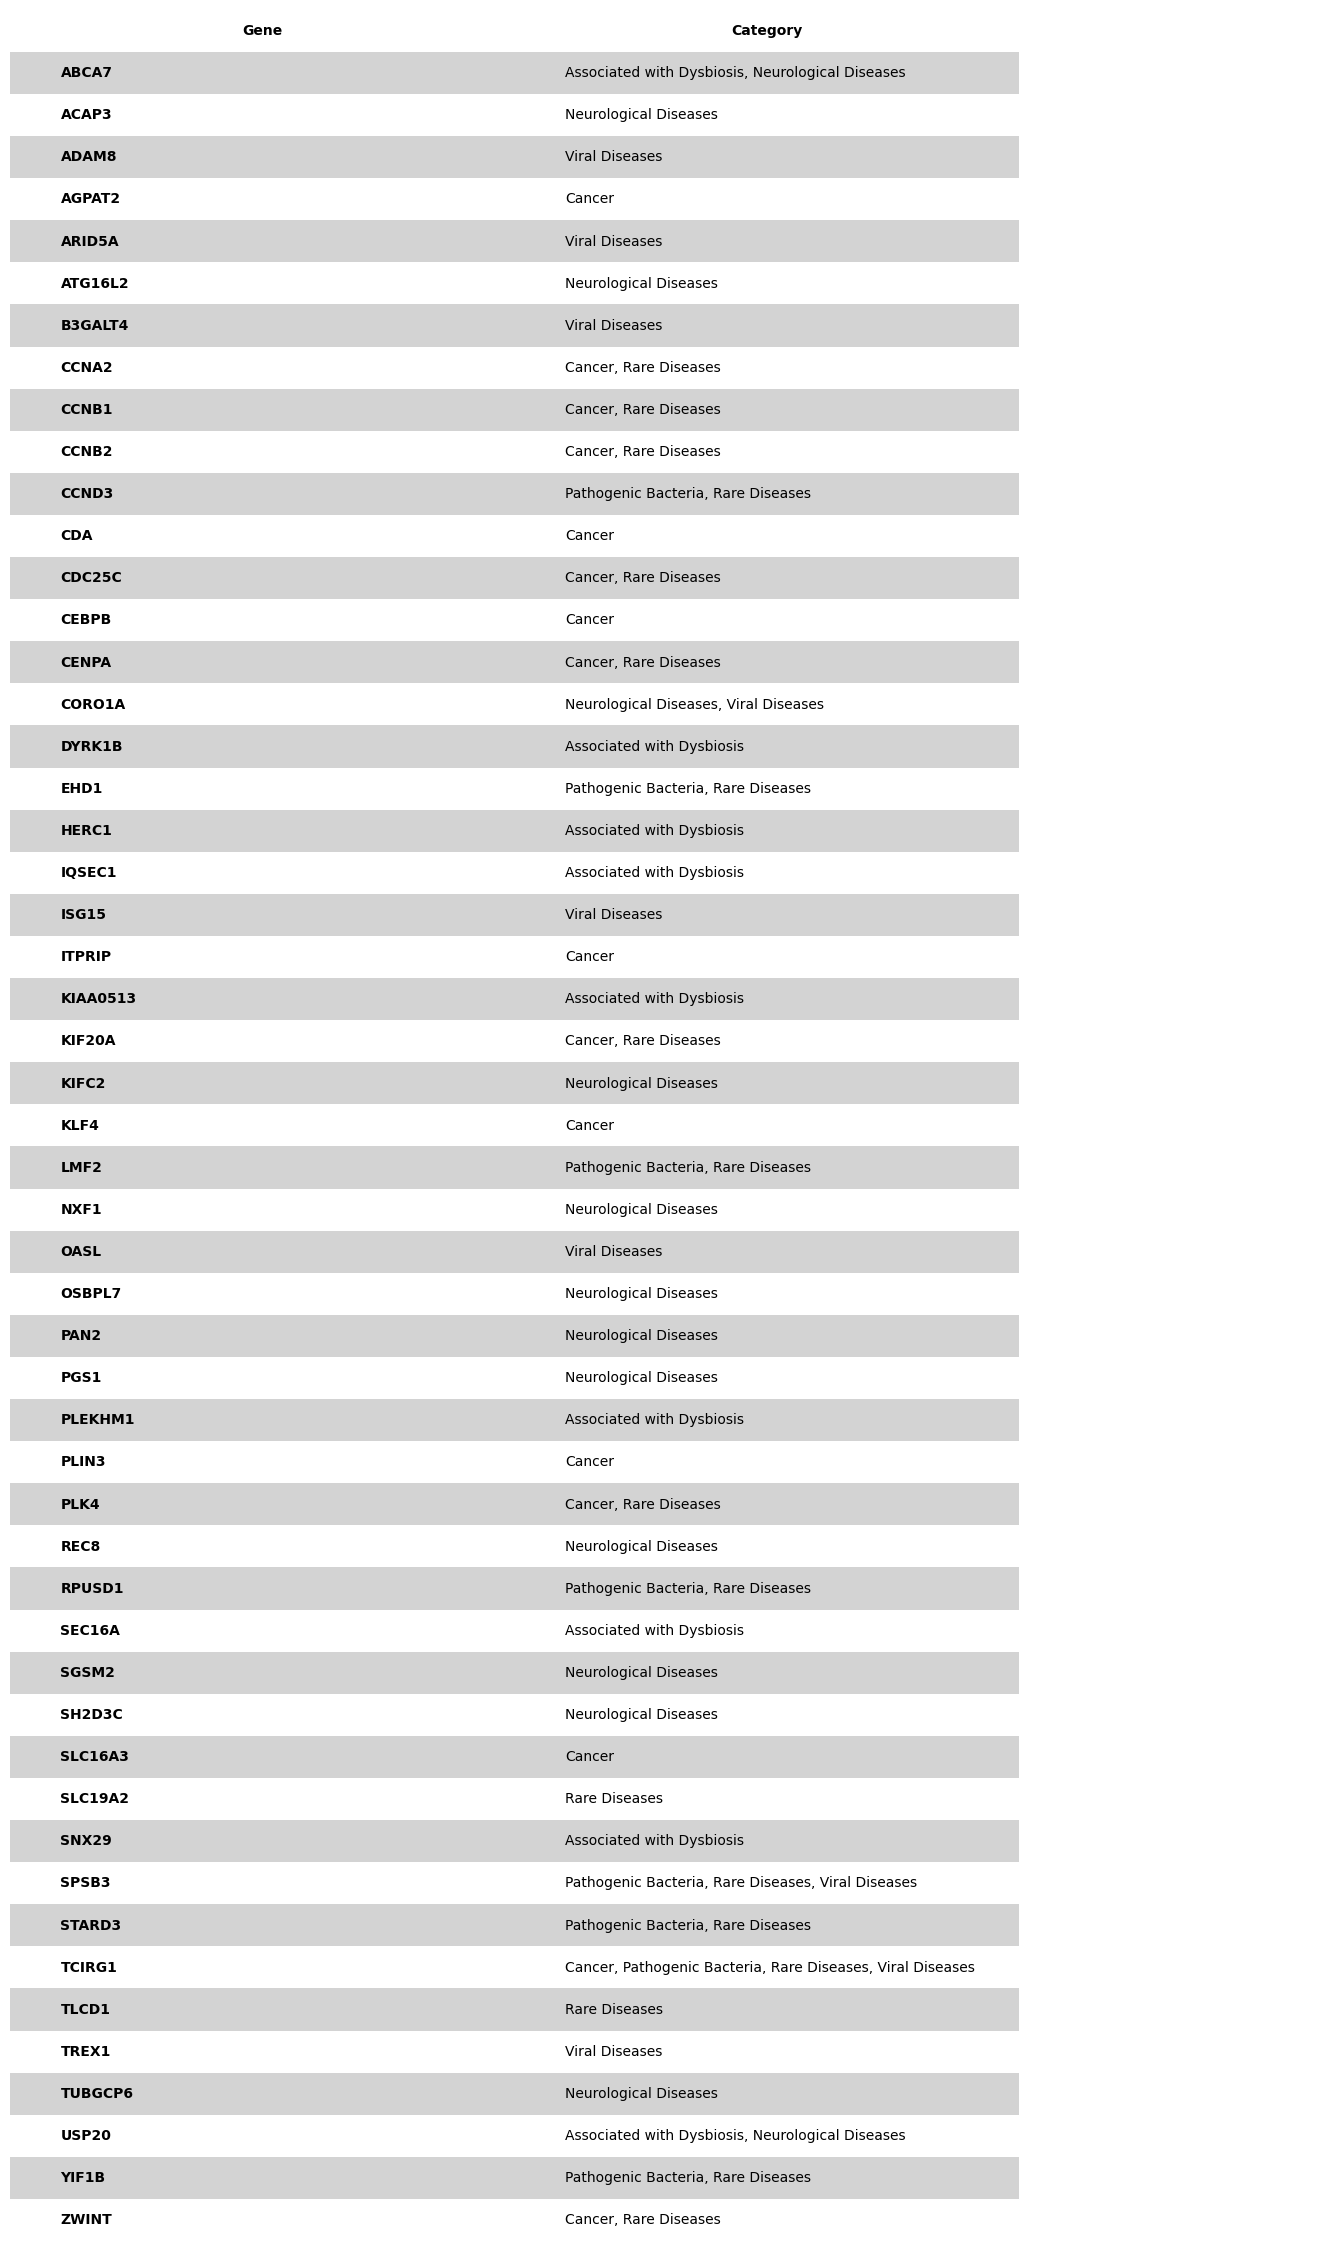

In [24]:

# df_genes_grouped = pd.read_csv('genes_grouped_by_category_filtered.csv')

# Ajustar el tamaño de la figura para evitar tamaño excesivo
fig, ax = plt.subplots(figsize=(15, 10))  # Ajusta el tamaño según sea necesario

# Eliminar los ejes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Crear una lista de colores para el sombreado alternado (sin la fila de encabezados)
num_rows = len(df_genes_grouped)
num_cols = len(df_genes_grouped.columns)
colors = [['white' if i % 2 else 'lightgray' for j in range(num_cols)] for i in range(num_rows)]

# Añadir la tabla a la figura
table = plt.table(cellText=df_genes_grouped.values, 
                  colLabels=df_genes_grouped.columns, 
                  cellLoc='left', 
                  loc='left',
                  cellColours= colors)  # Añadir la fila de encabezados en blanco

# Estilo de las celdas
for (i, j), val in np.ndenumerate(df_genes_grouped.values):
    if i == 0:  # La primera fila (títulos) en negrilla
        table[(i, j)].set_text_props(weight='bold')
    if j == 0:  # La primera columna (Gene) en negrilla
        table[(i + 1, j)].set_text_props(weight='bold')
    table[(i + 1, j)].set_fontsize(12)  # Ajustar el tamaño de la fuente de los datos

# Ajustar el estilo de las líneas
for key, cell in table._cells.items():
    cell.set_edgecolor('none')  # Eliminar el borde de todas las celdas

# Ajustar el tamaño de la tabla para evitar imagen demasiado grande
plt.tight_layout(pad=0.8)

# Ajustar el tamaño de las celdas y la fuente
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(3.2, 2.25)  # Ajustar escala si es necesario

# Guardar la tabla como imagen
plt.savefig('genes_grouped_table.png', bbox_inches='tight', dpi=300)

# Mostrar la imagen
plt.show()


Heatmap guardado como 'protein_interaction_heatmap.png'


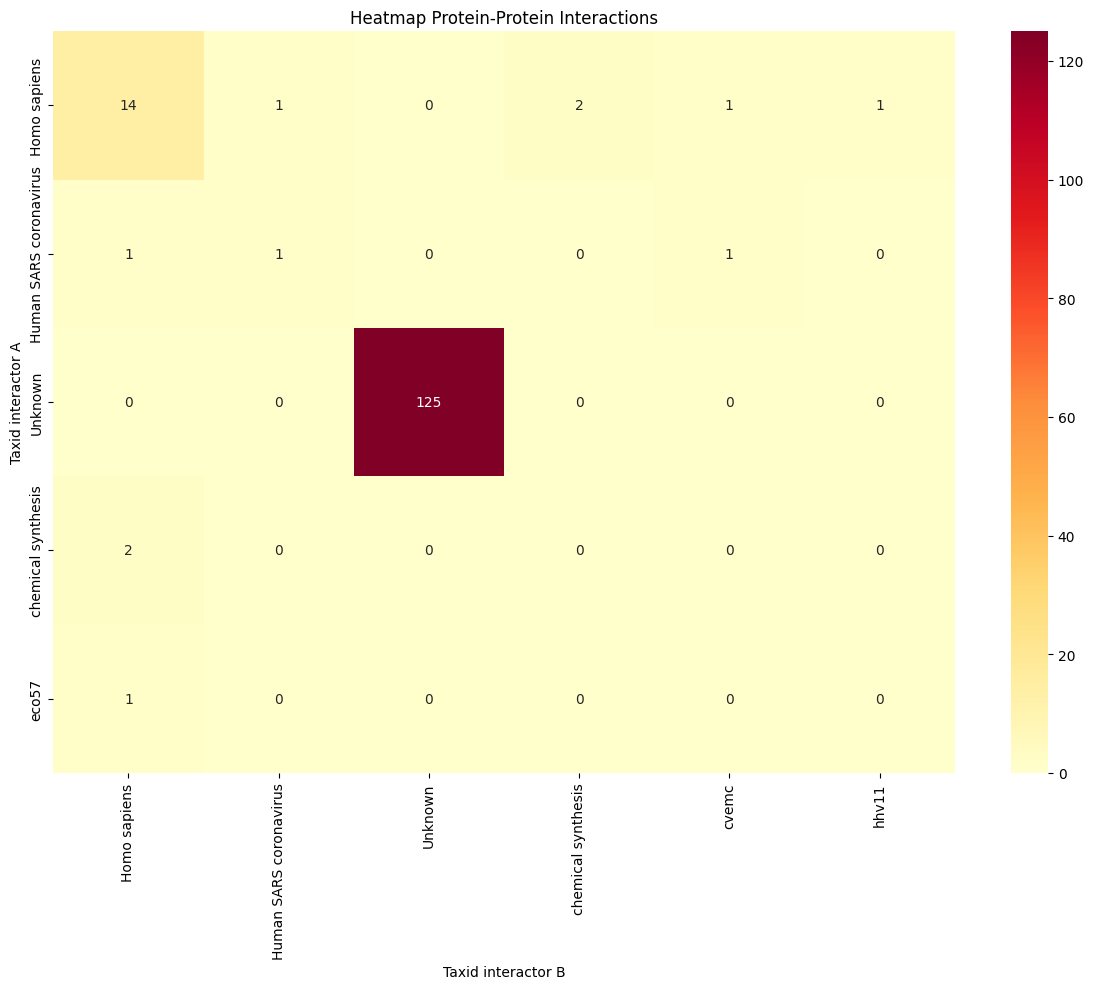

In [25]:
# Función para procesar los campos de taxa que pueden tener múltiples valores separados por ';'
def process_taxid_column(column):
    taxa = column.split(';')
    return [taxon.strip() for taxon in taxa]

# Procesar las columnas de interacciones para manejar múltiples taxones
interaction_df = df[['Genes', 'Taxid interactor A_Intact', 'Taxid interactor B_Intact']].copy()

# Rellenar valores nulos con 'Unknown' y separar los taxones
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].fillna('Unknown').apply(process_taxid_column)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].fillna('Unknown').apply(process_taxid_column)

# Expandir el DataFrame para tener una fila por cada combinación de taxa en interactor A e interactor B
interaction_df = interaction_df.explode('Taxid interactor A_Intact').explode('Taxid interactor B_Intact')

# Crear la matriz de interacciones
interaction_matrix = pd.crosstab(interaction_df['Taxid interactor A_Intact'], interaction_df['Taxid interactor B_Intact'])

# Generar el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Heatmap Protein-Protein Interactions')
plt.xlabel('Taxid interactor B')
plt.ylabel('Taxid interactor A')
plt.tight_layout()
plt.savefig('protein_interaction_heatmap.png')
print("Heatmap guardado como 'protein_interaction_heatmap.png'")



Contenido de confidence_matrix:
Taxid interactor B_Intact Homo sapiens Human SARS coronavirus Unknown  \
Taxid interactor A_Intact                                               
Homo sapiens                      0.61                   0.58     NaN   
Human SARS coronavirus            0.58                   0.58     NaN   
Unknown                            NaN                    NaN     0.0   
chemical synthesis               0.585                    NaN     NaN   
eco57                         0.633333                    NaN     NaN   

Taxid interactor B_Intact chemical synthesis cvemc hhv11  
Taxid interactor A_Intact                                 
Homo sapiens                           0.515  0.58  0.62  
Human SARS coronavirus                   NaN  0.58   NaN  
Unknown                                  NaN   NaN   NaN  
chemical synthesis                       NaN   NaN   NaN  
eco57                                    NaN   NaN   NaN  


C:\Users\3060\AppData\Local\Temp\ipykernel_1660\1775578015.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  confidence_matrix = confidence_matrix.fillna(0)


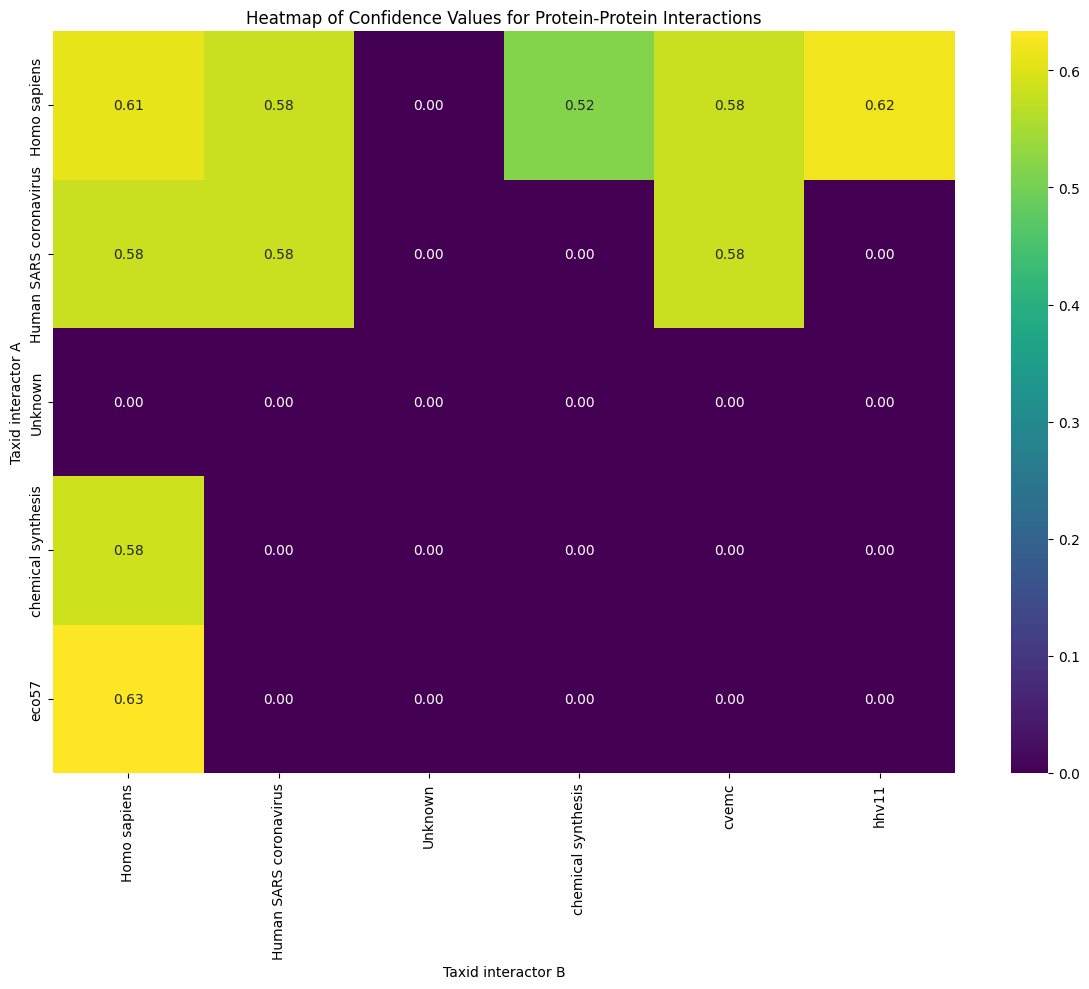

In [26]:


# Función para procesar columnas que contienen listas separadas por ";"
def process_column(column):
    if isinstance(column, str):
        return [item.strip() for item in column.split(';')]
    return []

# Función para procesar las columnas de confianza
def process_confidence_column(column):
    if isinstance(column, str):
        return [float(conf) for conf in process_column(column)]
    return []

# Procesar las columnas de interacciones para manejar múltiples taxones
interaction_df = df[['Genes', 'Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact', 'Host organism(s)_Intact']].copy()

# Procesar las columnas de interacciones para manejar múltiples valores
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].fillna('Unknown').apply(process_column)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].fillna('Unknown').apply(process_column)
interaction_df['Confidence value(s)_Intact'] = interaction_df['Confidence value(s)_Intact'].fillna('0').apply(process_confidence_column)

# Expandir el DataFrame para tener una fila por cada combinación de taxones y valores de confianza
interaction_df = interaction_df.explode('Taxid interactor A_Intact')
interaction_df = interaction_df.explode('Taxid interactor B_Intact')
interaction_df = interaction_df.explode('Confidence value(s)_Intact')

# Asegurarse de que las columnas no contengan listas
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].astype(str)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].astype(str)

# Crear la matriz de confianza entre Taxid interactor A y Taxid interactor B
confidence_matrix = pd.pivot_table(interaction_df, values='Confidence value(s)_Intact', index='Taxid interactor A_Intact', columns='Taxid interactor B_Intact', aggfunc='mean')

# Verificar el contenido de la matriz de confianza
print("Contenido de confidence_matrix:")
print(confidence_matrix)

# Manejar valores NaN en la matriz de confianza
confidence_matrix = confidence_matrix.fillna(0)

# Generar el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(confidence_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of Confidence Values for Protein-Protein Interactions')
plt.xlabel('Taxid interactor B')
plt.ylabel('Taxid interactor A')
plt.tight_layout()
plt.savefig('protein_interaction_confidence_heatmap.png')
plt.show()  # Mostrar el gráfico en lugar de solo guardarlo





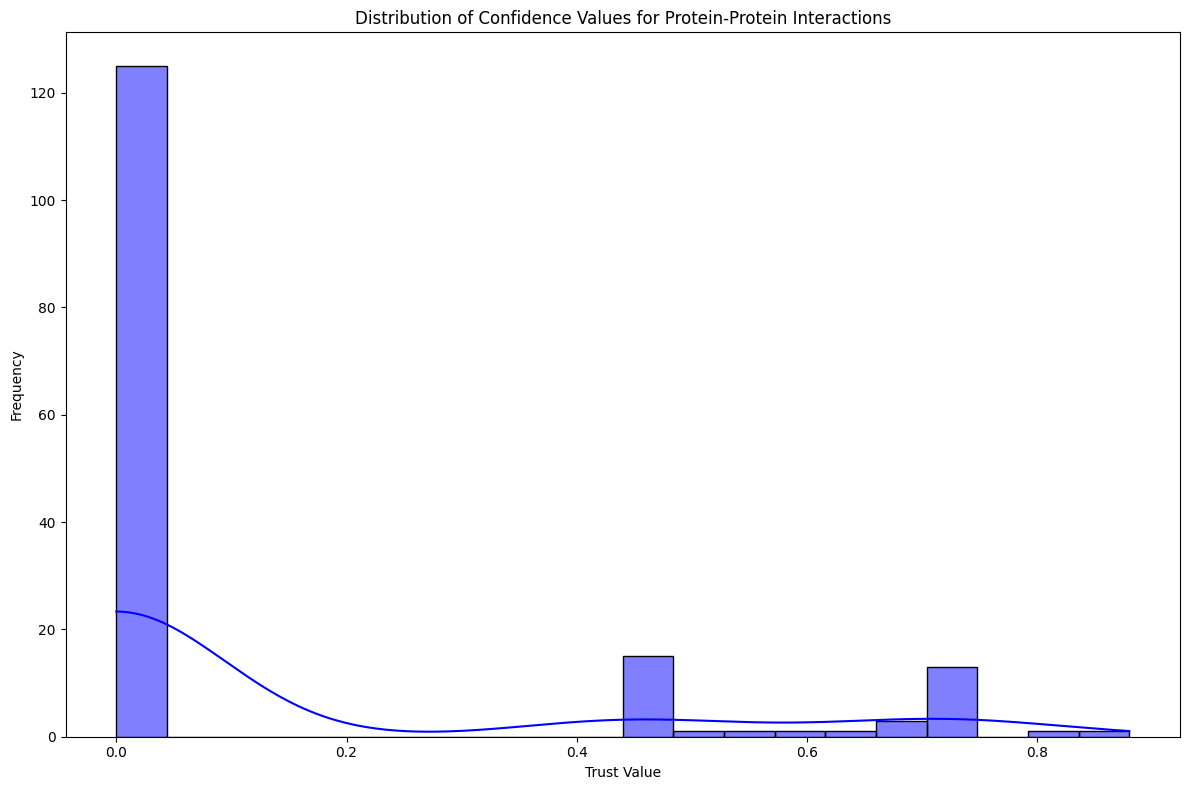

In [27]:
# Asumiendo que 'interaction_df' ya está procesado
plt.figure(figsize=(12, 8))

# Crear un gráfico de barras para la distribución de valores de confianza
sns.histplot(interaction_df['Confidence value(s)_Intact'], bins=20, kde=True, color='b')
plt.title('Distribution of Confidence Values for Protein-Protein Interactions')
plt.xlabel('Trust Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('confidence_distribution_bar_plot.png')
plt.show()

Taxid interactor A_Intact      object
Taxid interactor B_Intact      object
Confidence value(s)_Intact    float64
dtype: object
(162, 3)


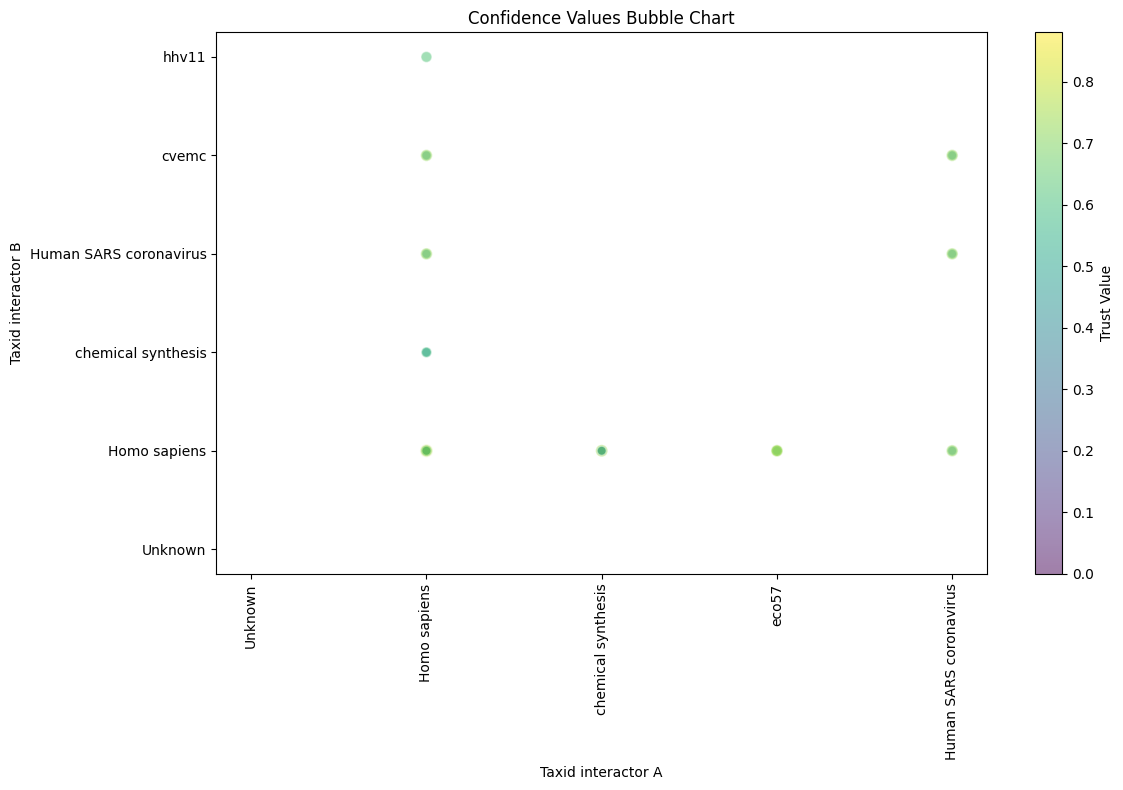

In [28]:
# Convertir la columna 'Confidence value(s)_Intact' a tipo numérico
interaction_df['Confidence value(s)_Intact'] = pd.to_numeric(interaction_df['Confidence value(s)_Intact'], errors='coerce')

# Eliminar filas con valores nulos en 'Confidence value(s)_Intact'
interaction_df = interaction_df.dropna(subset=['Confidence value(s)_Intact'])

# Verificar los tamaños y tipos después de la conversión
print(interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].dtypes)
print(interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].shape)

# Crear el gráfico de burbujas
plt.figure(figsize=(12, 8))

plt.scatter(
    interaction_df['Taxid interactor A_Intact'],
    interaction_df['Taxid interactor B_Intact'],
    s=interaction_df['Confidence value(s)_Intact'] * 100,  # Tamaño de la burbuja
    alpha=0.5,
    c=interaction_df['Confidence value(s)_Intact'],  # Color según el valor de confianza
    cmap='viridis',  # Mapa de colores
    edgecolors='w'
)

plt.title('Confidence Values Bubble Chart')
plt.xlabel('Taxid interactor A')
plt.ylabel('Taxid interactor B')
plt.colorbar(label='Trust Value')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('confidence_bubble_chart.png')
plt.show()

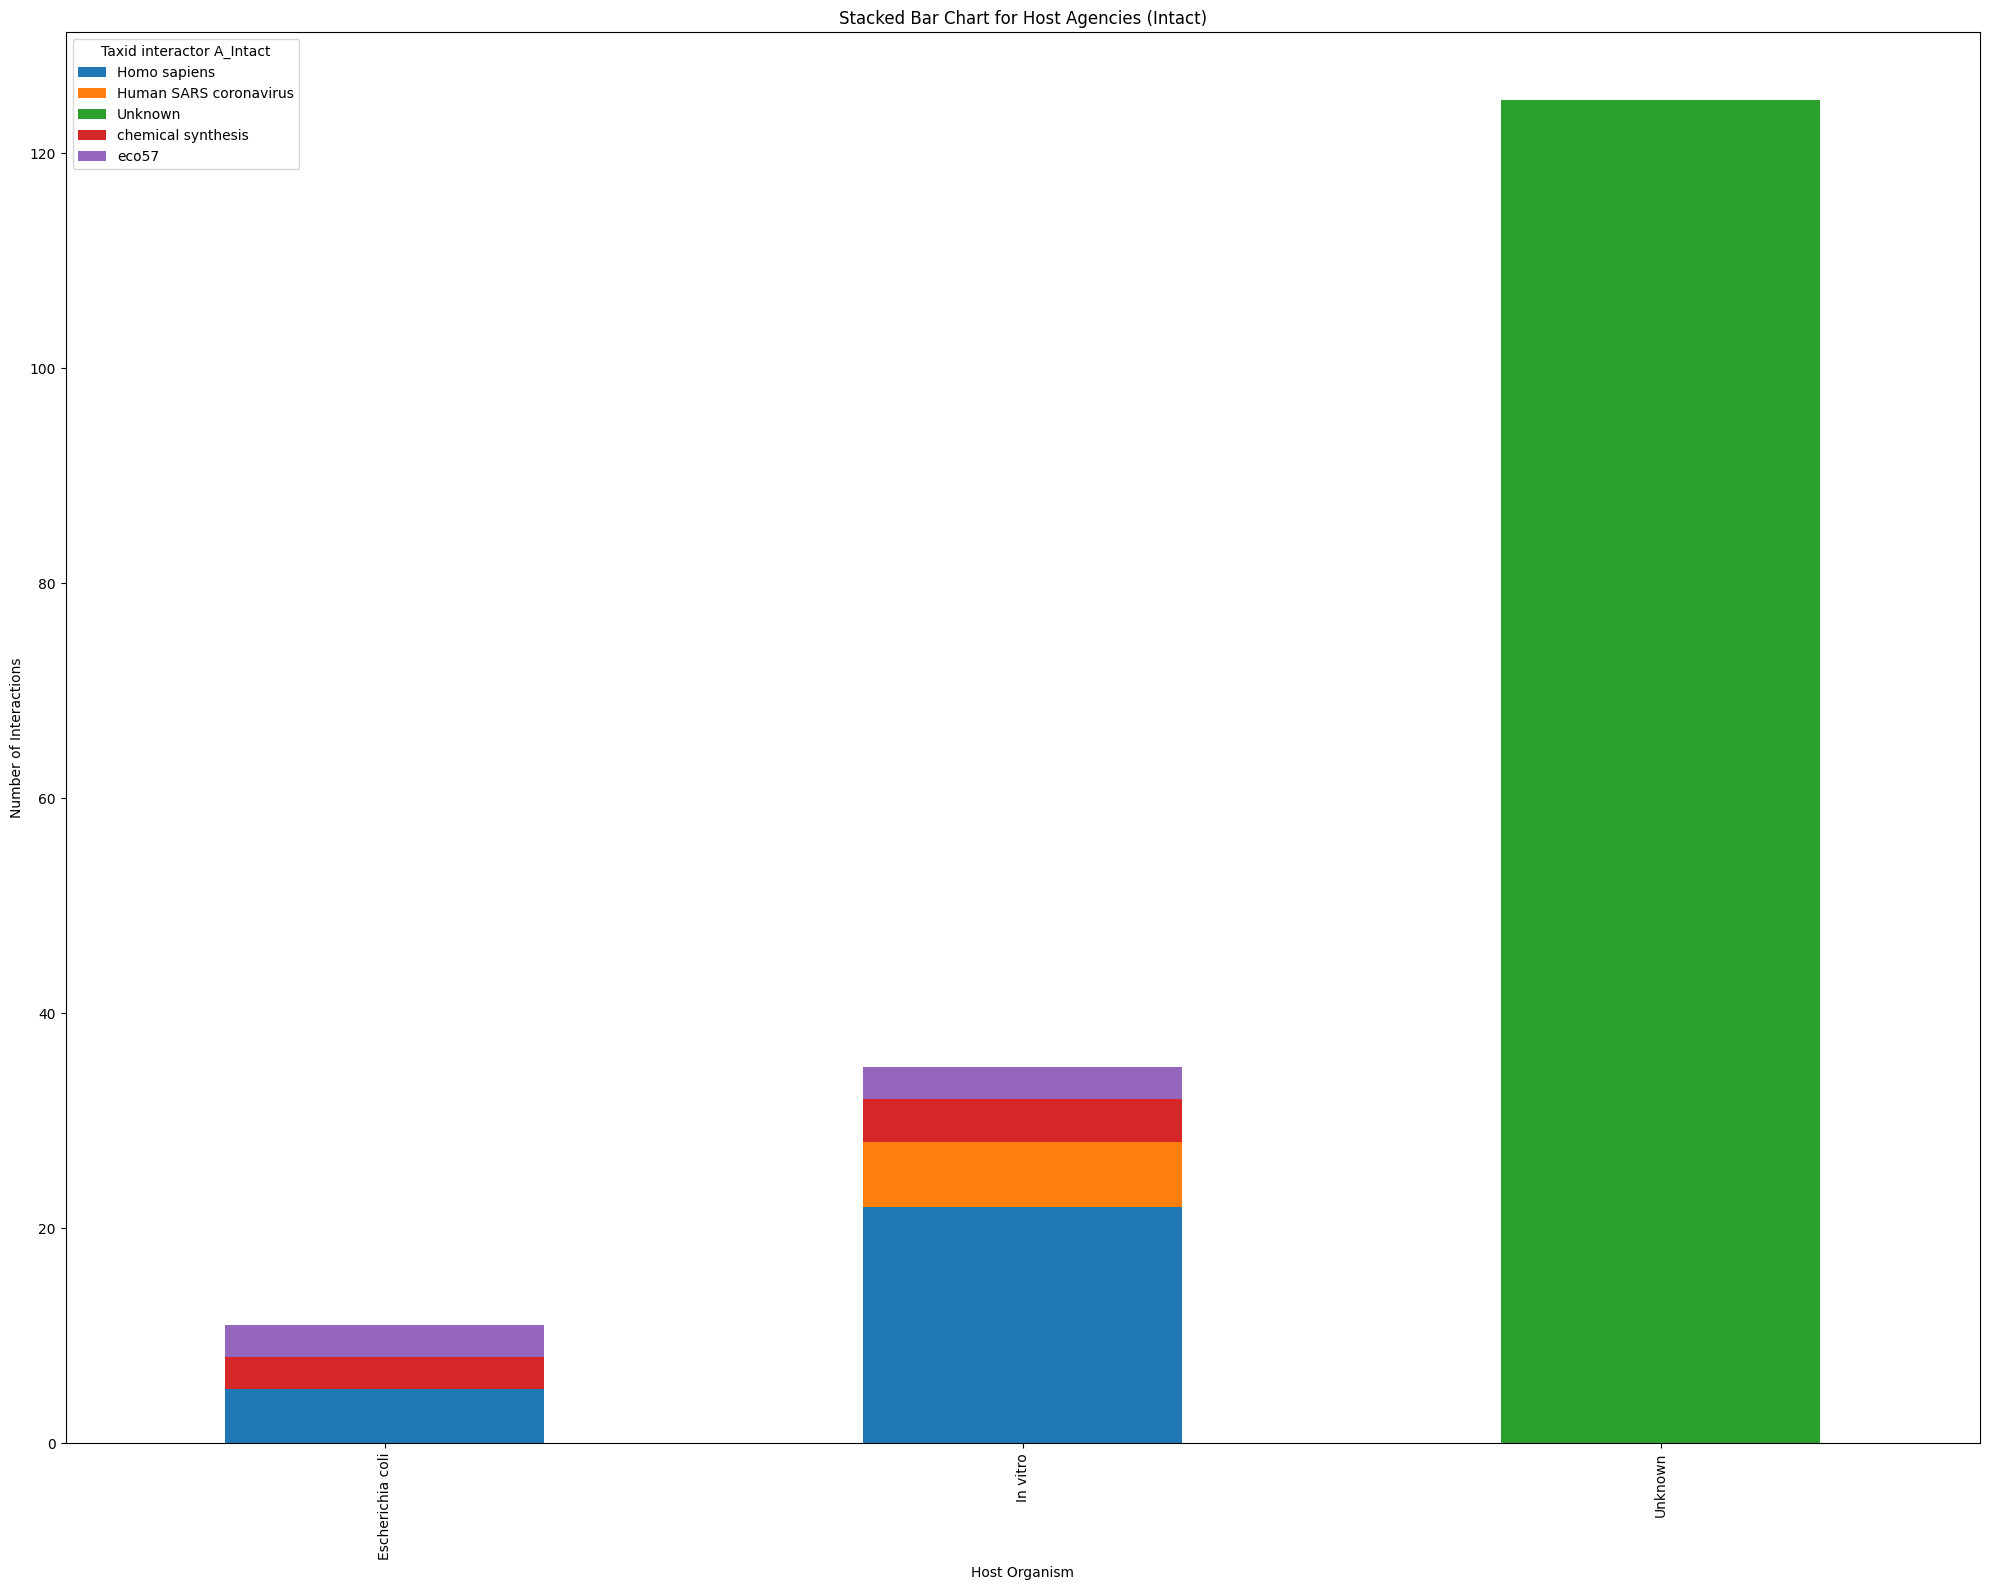

In [29]:
# Supongamos que tienes una columna 'Host organism(s)_Intact' en 'interaction_df'
interaction_df['Host organism(s)_Intact'] = interaction_df['Host organism(s)_Intact'].fillna('Unknown').apply(process_column)

# Expandir los organismos anfitriones
interaction_df = interaction_df.explode('Host organism(s)_Intact')

# Crear una tabla de datos para el gráfico apilado
host_data = interaction_df.groupby(['Host organism(s)_Intact', 'Taxid interactor A_Intact']).size().unstack(fill_value=0)

# Generar el gráfico de barras apiladas
host_data.plot(kind='bar', stacked=True, figsize=(20, 16))
plt.title('Stacked Bar Chart for Host Agencies (Intact)')
plt.xlabel('Host Organism')
plt.ylabel('Number of Interactions')
plt.tight_layout()
plt.savefig('stacked_bar_plot_host_organisms.png')
plt.show()

<Figure size 2400x2200 with 0 Axes>

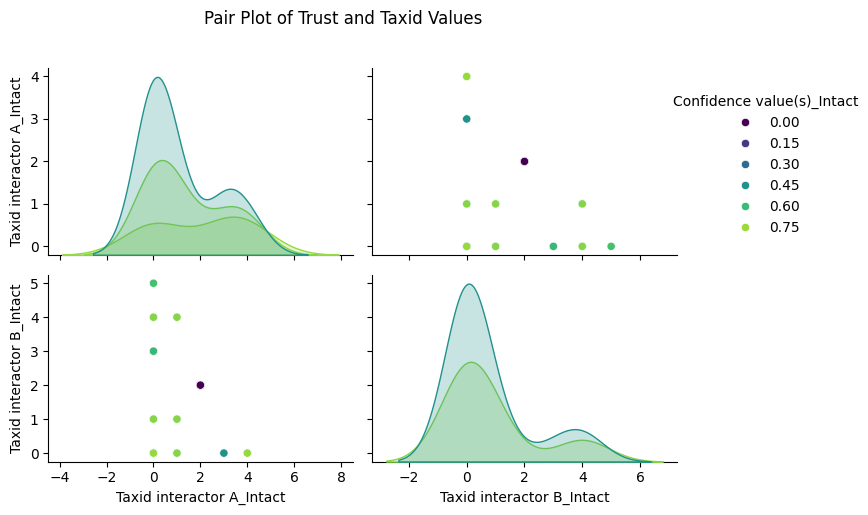

In [30]:
# Crear un DataFrame con valores numéricos para Pair Plot
pair_plot_df = interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].copy()

# Convertir los taxones a categorías para el pairplot
pair_plot_df['Taxid interactor A_Intact'] = pair_plot_df['Taxid interactor A_Intact'].astype('category').cat.codes
pair_plot_df['Taxid interactor B_Intact'] = pair_plot_df['Taxid interactor B_Intact'].astype('category').cat.codes

# Ajustar el tamaño de la figura
plt.figure(figsize=(24, 22))  # Ajusta el tamaño según tus necesidades

# Generar el Pair Plot
pair_plot = sns.pairplot(pair_plot_df, hue='Confidence value(s)_Intact', palette='viridis')

# Añadir título
pair_plot.fig.suptitle('Pair Plot of Trust and Taxid Values', y=1.02)

# Ajustar la posición de la leyenda
pair_plot._legend.set_bbox_to_anchor((1.25, 0.7))  # Ajusta la posición (x, y) según sea necesario

# Ajustar el layout
plt.tight_layout()
plt.savefig('pair_plot_confidence_taxid.png')
plt.show()

Heatmap guardado como 'gene_virus_host_heatmap.png'


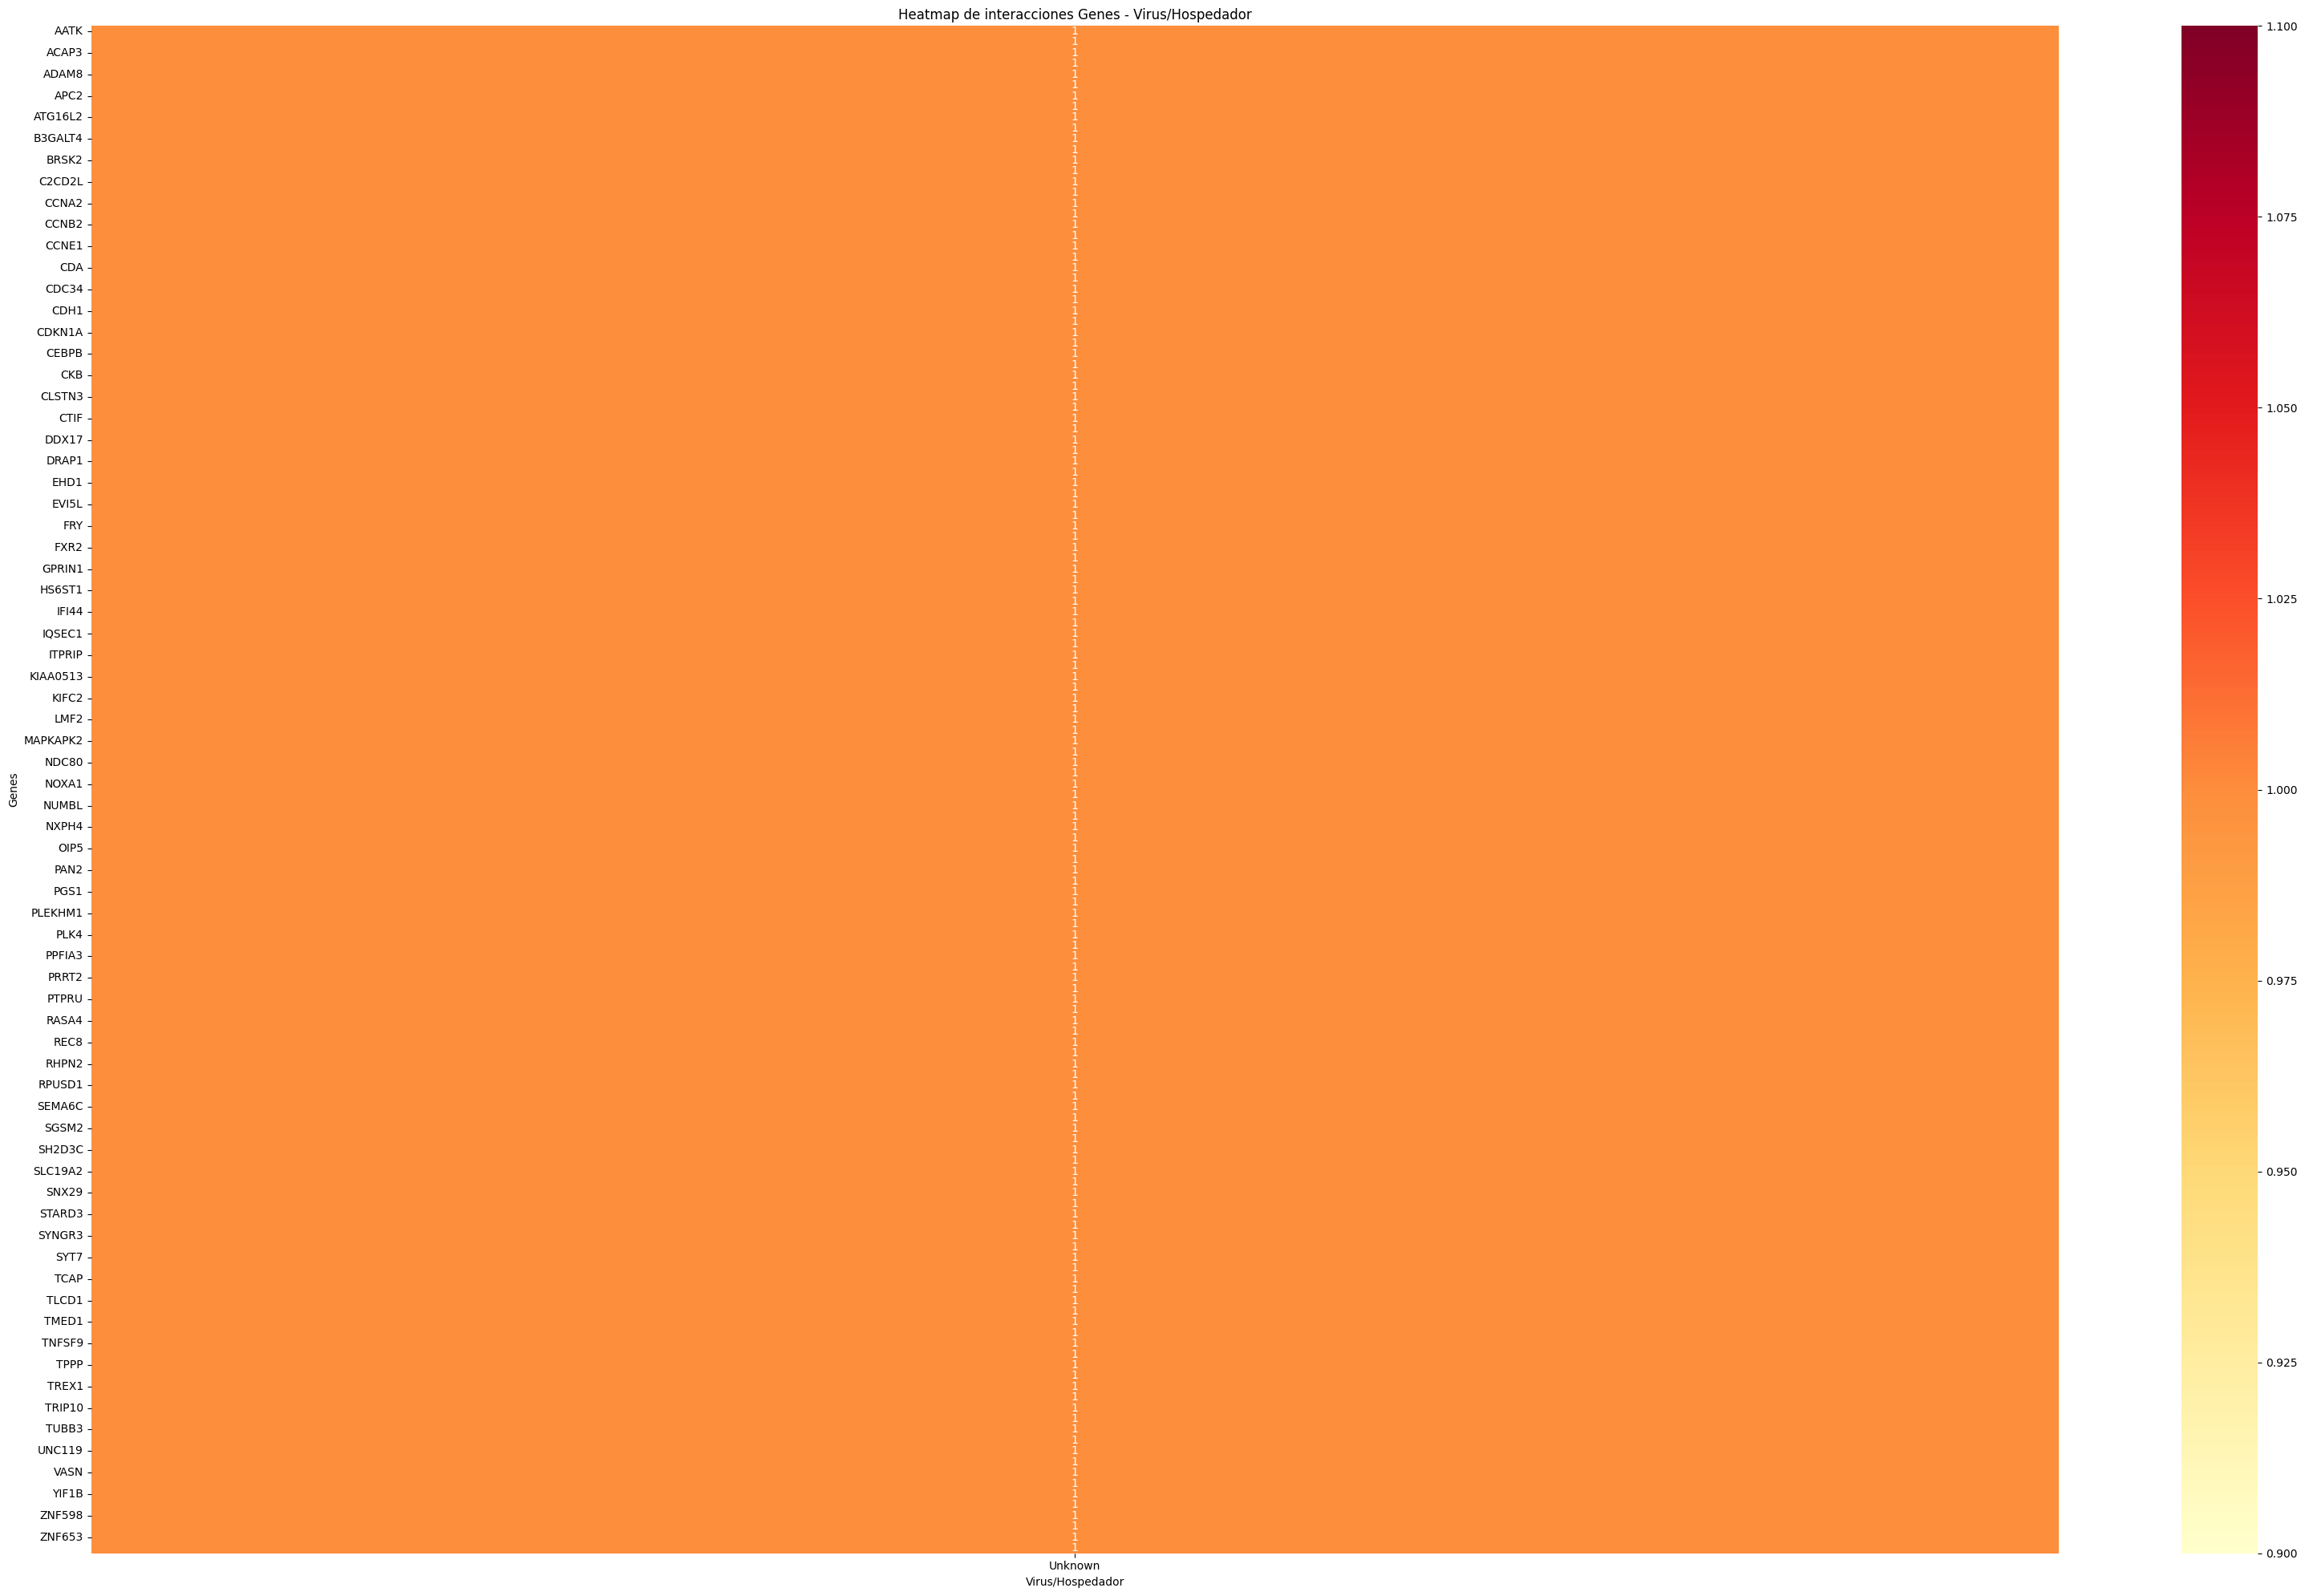

In [31]:
# Procesar las columnas de genes y términos de virus/hospedador para manejar múltiples valores
def process_column(column):
    terms = column.split(';')
    return [term.strip() for term in terms]

# Crear una copia del DataFrame y procesar las columnas relevantes
interaction_df = df[['Genes', 'Virus_Host_Term']].copy()

# Rellenar valores nulos con 'Unknown' y separar los términos
interaction_df['Genes'] = interaction_df['Genes'].fillna('Unknown')
interaction_df['Virus_Host_Term'] = interaction_df['Virus_Host_Term'].fillna('Unknown').apply(process_column)

# Expandir el DataFrame para tener una fila por cada combinación de genes y términos de virus/hospedador
interaction_df = interaction_df.explode('Genes').explode('Virus_Host_Term')

# Crear la matriz de interacciones entre Genes y Virus_Host_Term
interaction_matrix = pd.crosstab(interaction_df['Genes'], interaction_df['Virus_Host_Term'])

# Generar el heatmap
plt.figure(figsize=(32, 20))
sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Heatmap de interacciones Genes - Virus/Hospedador')
plt.xlabel('Virus/Hospedador')
plt.ylabel('Genes')
plt.tight_layout()
plt.savefig('gene_virus_host_heatmap.png')
print("Heatmap guardado como 'gene_virus_host_heatmap.png'")


In [32]:
def process_column(column):
    if pd.isna(column):
        return []  # Manejo de valores NaN
    return [item.strip() for item in column.split(';')]

def filter_top_interactions(df, top_n=50):
    df_expanded = df.copy()
    df_expanded['Virus_Host_Term'] = df_expanded['Virus_Host_Term'].apply(process_column)
    df_expanded['Virus_Host_Pvalue_Adjusted'] = df_expanded['Virus_Host_Pvalue_Adjusted'].apply(lambda x: [float(p) if p.strip() else float('nan') for p in process_column(x)])
    
    df_expanded = df_expanded.explode('Genes')
    df_expanded = df_expanded.explode('Virus_Host_Term')
    df_expanded = df_expanded.explode('Virus_Host_Pvalue_Adjusted')
    
    df_expanded = df_expanded.dropna(subset=['Virus_Host_Pvalue_Adjusted'])  # Eliminar filas con Pvalue NaN
    df_expanded['Virus_Host_Pvalue_Adjusted'] = df_expanded['Virus_Host_Pvalue_Adjusted'].astype(float)  # Convertir a float
    
    df_filtered = df_expanded.sort_values(by='Virus_Host_Pvalue_Adjusted').groupby(['Genes', 'Virus_Host_Term']).first().reset_index()
    df_filtered = df_filtered.nsmallest(top_n, 'Virus_Host_Pvalue_Adjusted')
    
    return df_filtered

# Aplicar el filtro para obtener las mejores 50 interacciones
interaction_df = df[['Genes', 'Virus_Host_Term', 'Virus_Host_Pvalue_Adjusted']].copy()
filtered_df = filter_top_interactions(interaction_df, top_n=50)

# Verificar si filtered_df está vacío
if filtered_df.empty:
    print("El DataFrame filtrado está vacío. No se puede generar el heatmap.")
else:
    # Crear la matriz de interacciones entre Genes y Virus_Host_Term
    interaction_matrix = pd.crosstab(filtered_df['Genes'], filtered_df['Virus_Host_Term'])
    
    # Generar el heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
    plt.title('Heatmap of top 50 Genes - Virus/Host interactions (based on Pvalue_Adjusted)')
    plt.xlabel('Virus/Host')
    plt.ylabel('Genes')
    plt.tight_layout()
    plt.savefig('top50_gene_virus_host_heatmap.png')
    print("Heatmap guardado como 'top50_gene_virus_host_heatmap.png'")

El DataFrame filtrado está vacío. No se puede generar el heatmap.


Scatter plot guardado como 'top50_gene_virus_host_scatterplot.png'


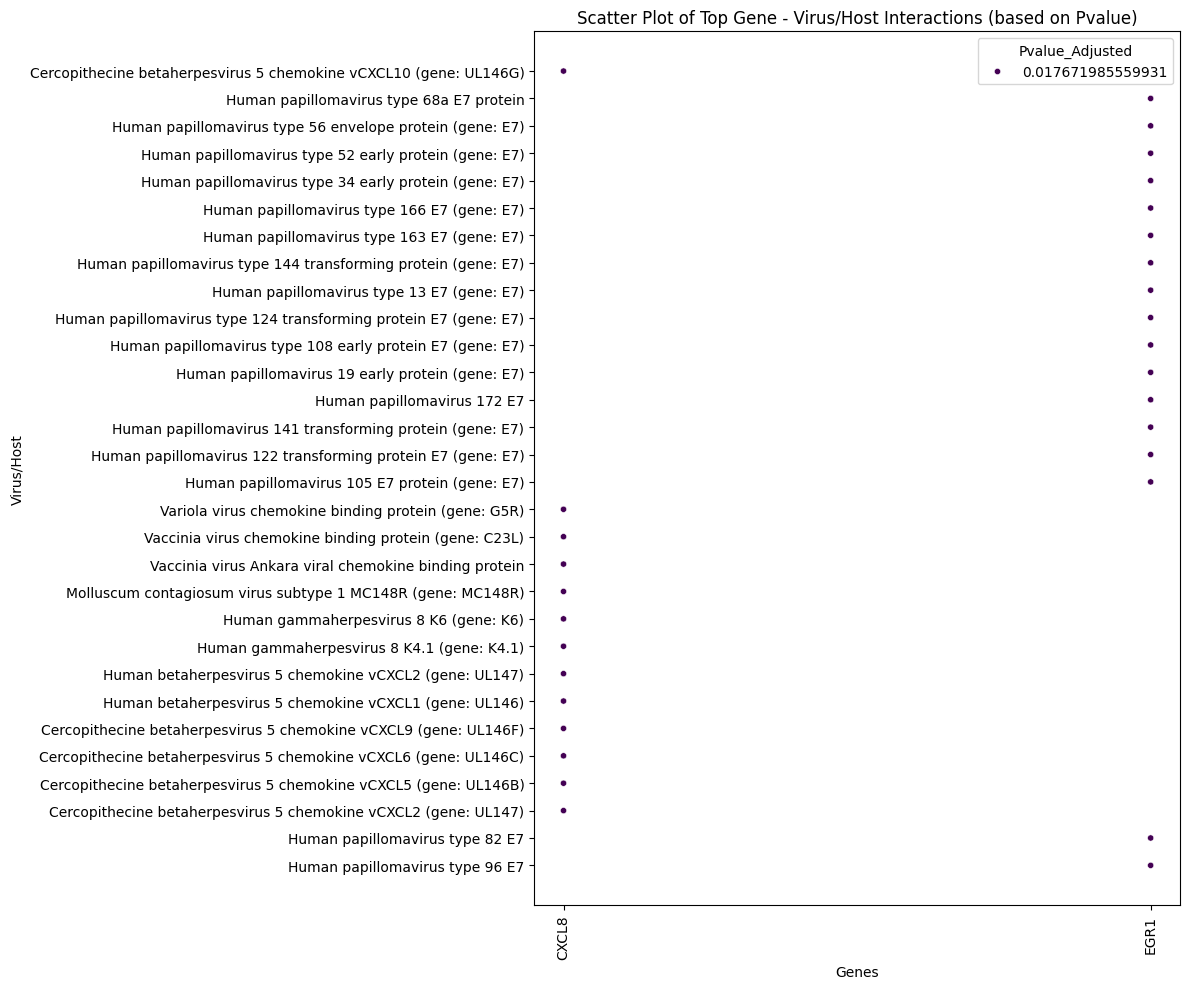

In [55]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=filtered_df, x='Genes', y='Virus_Host_Term', size='Virus_Host_Pvalue_Adjusted', hue='Virus_Host_Pvalue_Adjusted', palette='viridis', sizes=(20, 200))
plt.title('Scatter Plot of Top Gene - Virus/Host Interactions (based on Pvalue)')
plt.xlabel('Genes')
plt.ylabel('Virus/Host')
plt.legend(title='Pvalue_Adjusted')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('top50_gene_virus_host_scatterplot.png')
print("Scatter plot guardado como 'top50_gene_virus_host_scatterplot.png'")


Bar plot guardado como 'virus_host_interaction_counts.png'


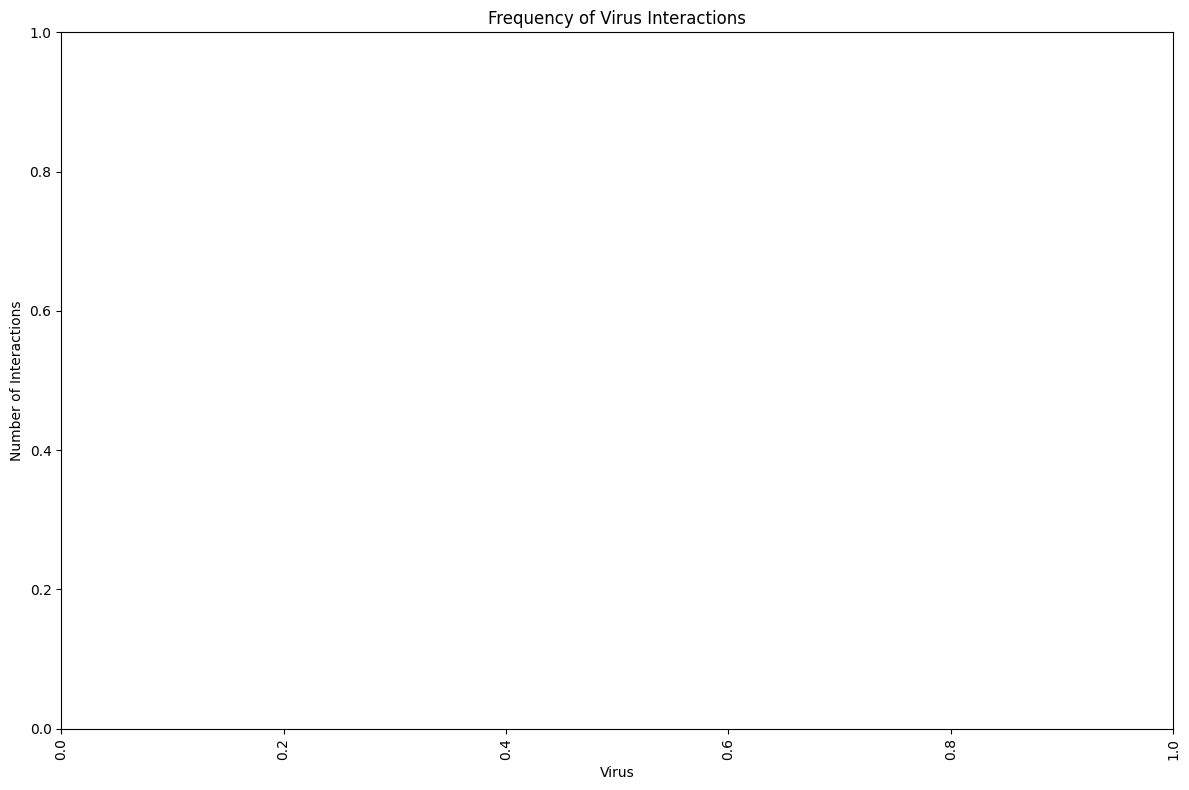

In [33]:

# Contar las interacciones por Virus_Host_Term
interaction_counts = filtered_df['Virus_Host_Term'].value_counts().reset_index()
interaction_counts.columns = ['Virus_Host_Term', 'Count']

plt.figure(figsize=(12, 8))
sns.barplot(data=interaction_counts, x='Virus_Host_Term', y='Count', palette='viridis')
plt.title('Frequency of Virus Interactions')
plt.xlabel('Virus')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('virus_host_interaction_counts.png')
print("Bar plot guardado como 'virus_host_interaction_counts.png'")


Obtener los archivos de nodos y aristas para crear la red en Cytoscape

In [9]:


# Cargar el archivo CSV
file_path = 'Integracion_con_patógenos_y_enfermedades_Bacillus_Subtilis_Padj_menor_0.5.csv'
data = pd.read_csv(file_path)

# Crear listas para nodos y aristas
nodos = set()
aristas = []

# Iterar sobre cada fila del DataFrame
for index, row in data.iterrows():
    gene = row['Genes']
    nodos.add((gene, 'Gene'))  # Agregar el gen como nodo

    # Procesar las columnas de enfermedades
    for term, pvalue_column in zip(['DisGeNET_Term', 'GeDiPNet_Term', 'Orphanet_Term'],
                                   ['DisGeNET_Pvalue_Adjusted', 'GeDiPNet_Pvalue_Adjusted', 'Orphanet_Pvalue_Adjusted']):
        if pd.notna(row[term]):  # Verificar que no sea NaN
            enfermedades = row[term].split(';')  # Separar por punto y coma
            pvalues = str(row[pvalue_column]).split(';')  # Separar los valores P correspondientes
            for enfermedad, pvalue in zip(enfermedades, pvalues):
                if float(pvalue) < 0.05:  # Verificar que el valor P ajustado sea menor a 0.05
                    enfermedad_str = enfermedad.strip().replace(",", "")  # Eliminar comas
                    aristas.append((gene, enfermedad_str, float(pvalue)))  # Crear arista con pvalue
                    nodos.add((enfermedad_str, 'Disease'))  # Agregar enfermedad como nodo

    # Procesar las columnas de patógenos
    if pd.notna(row['Virus_Host_Term']):  # Verificar que no sea NaN
        patogenos = row['Virus_Host_Term'].split(';')  # Separar por punto y coma
        pvalues = str(row['Virus_Host_Pvalue_Adjusted']).split(';')  # Separar los valores P correspondientes
        for patogeno, pvalue in zip(patogenos, pvalues):
            if float(pvalue) < 0.05:  # Verificar que el valor P ajustado sea menor a 0.05
                patogeno_str = patogeno.strip().replace(",", "")  # Eliminar comas
                aristas.append((gene, patogeno_str, float(pvalue)))  # Crear arista con pvalue
                nodos.add((patogeno_str, 'Pathogen'))  # Agregar patógeno como nodo

# Crear DataFrame de nodos
nodos_df = pd.DataFrame(list(nodos), columns=['Id', 'Type'])

# Guardar el archivo de nodos
nodos_df.to_csv('nodos.csv', index=False)

# Crear DataFrame de aristas
aristas_df = pd.DataFrame(aristas, columns=['Source', 'Target', 'Pvalue_Adjusted'])

# Eliminar duplicados en aristas
aristas_df = aristas_df.drop_duplicates()

# Guardar el archivo de aristas
aristas_df.to_csv('aristas.csv', index=False)
